In [1]:
from nltk.stem.wordnet import WordNetLemmatizer
import pandas as pd
import numpy as np
import string
from gensim import corpora
import gensim
from nltk.corpus import words
from gensim.models import LdaModel, LsiModel, Word2Vec, CoherenceModel
from gensim.corpora import Dictionary
import pyLDAvis.gensim
import matplotlib.pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA
from collections import defaultdict
from spacy.lang.en import STOP_WORDS
from pprint import pprint

In [2]:
# Topic coherence and its graph, top topics

In [2]:
# configure number of worker for multicore
import multiprocessing
cpu_count = multiprocessing.cpu_count()
worker = cpu_count - 1
print "No of worker to be used = %s"%worker

No of worker to be used = 7


In [3]:
# stop words
stop_wrd = []
with open('stopword.txt') as f:
    for c in f:
        c = c.replace(",","").replace("\n","").replace('"',"").strip()
        stop_wrd.append(c)
stop = list(STOP_WORDS)
print(len(stop))

305


# Creating Functions

In [4]:
# read document using filename
def read_document(file_name):
    print "Reading Document %s"%file_name
    temp = []
    with open(file_name) as f:
        for l in f:
            temp.append(l)
    print "Document Finished Reading"
    temp = clean_document(temp)
    return temp

In [5]:
def clean_document(doc_complete):
    print "Document Cleaning Started"
    doc_clean = []
    exclude = set(string.punctuation) 
    lemma = WordNetLemmatizer()
    def clean(doc):
        stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
        punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
        stop_free = " ".join([i for i in punc_free.split() if i not in stop_wrd])
        stop_free = ' '.join(i for i in stop_free.split() if not i.startswith('u0'))
        stop_free = " ".join([i for i in stop_free.lower().split() if not unicode(i, 'utf-8').isnumeric()])
        normalized = " ".join(lemma.lemmatize(word) for word in stop_free.split())
        return normalized
    doc_clean = [clean(doc).split() for doc in doc_complete]
    print "Document Cleaning Ended"
    return doc_clean

In [6]:
# return token frequency , clean document (using frequency of token)
def frequency_calculate(doc_clean):
    frequency = defaultdict(int)
    for text in doc_clean:
        for token in text:
            frequency[token] += 1        
    # make new text data by removing out the token that have occurence less then 2
    minimum_freq = 1
    len_of_token = 2
    # doc_clean = [[token for token in text if frequency[token] > minimum_freq]
    #           for text in doc_clean]
    doc_clean = [[token for token in text if len(token) > len_of_token and frequency[token] > minimum_freq]
              for text in doc_clean]
    
    return frequency, doc_clean

# LDA (Latent Dirichlet Allocation) Model -- Based on Probabilistic Graphical Models 

<div class="alert alert-block alert-info"> <font color='Blue'> Interpreting pyLDAvis output:
<ul> <li>Bubbles on the left-hand side of plot represents a topic. Larger the bubble, the more prevalent is that topic. </li>
<li>Good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. </li>
<li>Model with too many topics, will have many overlaps, small sized bubbles are clustered in one region of the chart.</li>
<li>The words on the right-hand side are the salient keywords that form the selected topic.</li>
<li>The red bars represent the frequency of a term in a given topic, and the blue bars represent term's frequency across the entire corpus.</li> </ul></font> </div>

In [7]:
def prepare_lda_prerequisite(doc_clean):
    dictionary = corpora.Dictionary(doc_clean)
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    return dictionary, doc_term_matrix

In [8]:
def run_lda(dictionary,doc_term_matrix,num_topics=100):
    Lda = gensim.models.ldamulticore.LdaMulticore
    ldamodel = Lda(doc_term_matrix, num_topics=num_topics, id2word = dictionary, passes=20, workers=worker)
    return ldamodel

In [9]:
def make_pyLDAvis(model,doc_term_matrix,dictionary):
    pyLDAvis.enable_notebook()
    py = pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

# LSI Model - (Latent Semantic Analysis) 

<div class="alert alert-block alert-info"><font color = 'blue'>Learns latent topics by performing matrix decomposition (SVD) on the term-document matrix
LSI finds low-dimension representation of documents and words.
Faster to train than LDA, but has lower accuracy. </font> </div>

In [10]:
def run_lsi(doc_term_matrix,dictionary,num_topics=100):
    model = LsiModel(doc_term_matrix, id2word=dictionary,num_topics=num_topics)  # train model
    return model

In [11]:
def print_lsi(model,num_topics=200):
    for c in model.print_topics(num_topics):
        print c

# Heat map 
<div class="alert alert-block alert-info"><font color = 'blue'> Strength of color bar represents normalized ratio of how often a topic X is mentioned in Document Y </font> </div>

In [12]:
def heat_map(model):
    K = model.num_topics
    columns = []
    columns_dict = {}
    for k in range(1,K+1):
        columns.append(str(k))
        columns_dict[k-1] = ""
    df = pd.DataFrame(columns = columns)
    pd.set_option('display.width', 1000)
    zz = np.zeros(shape=(1000,K))
    last_number=0
    DC={}
    for x in range (10):
      data = pd.DataFrame(columns_dict,index=[0])
      df=df.append(data,ignore_index=True)  
    for line in model.print_topics(num_topics=K):
        tp, w = line
        #print tp
        probs=w.split("+")
        y=0
        for pr in probs:
            a=pr.split("*")
            df.iloc[y,tp] = a[1]       
            if a[1] in DC:
               zz[DC[a[1]]][tp]=a[0]
            else:
               zz[last_number][tp]=a[0]
               DC[a[1]]=last_number
               last_number=last_number+1
            y=y+1
    
    zz=np.resize(zz,(len(DC.keys()),zz.shape[1]))
    plt.figure(figsize = (8,14))
    plt.pcolor(zz,norm=None, cmap='Blues')
    plt.colorbar(cmap='Blues')
    plt.imshow(zz, cmap='Blues', interpolation='nearest',aspect='auto')
    for val, key in enumerate(DC.keys()):
            plt.text(-2.5, val + 0.5, key,
                     horizontalalignment='left',
                     verticalalignment='top'
                     )
    plt.gca().invert_yaxis()      # flip the y-axis so the texts are in the order
    plt.tight_layout()            # fixes margins
    plt.show()

# PCA (Principal Component Analysis) 

<div class="alert alert-block alert-info"><font color = 'blue'> Statistical procedure to convert a set of observations of correlated variables into set of values of linearly uncorrelated variables called principal componets. </font> </div> 

In [13]:
def pca_scatter_graph(doc_clean):
    sentences = doc_clean
    model = Word2Vec(sentences,workers=3)
    X = model[model.wv.vocab]
    pca = PCA(n_components=2)
    result = pca.fit_transform(X)
    plt.figure(figsize = (20,20))
    # create a scatter plot of the projection
    plt.scatter(result[:, 0], result[:, 1])
    words = list(model.wv.vocab)
    for i, word in enumerate(words):
        plt.annotate(word, xy=(result[i, 0], result[i, 1]))
    plt.show()

# <div class="alert alert-block alert-info"><font color='red'> Non-Anonymous User (Negative Comments) <font>  </div>

In [14]:
# read the document
doc_cleaned = read_document('verified_negativecomment.txt')

Reading Document verified_negativecomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [16]:
# frequency_doc = frequency_calculate(doc_cleaned)

In [15]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


In [16]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
64     2.057337        1       1 -0.216003  0.017589
51     1.988144        1       2 -0.210329 -0.071433
19     1.966845        1       3 -0.068554 -0.014302
65     1.936854        1       4 -0.131075 -0.044562
74     1.932576        1       5 -0.186524 -0.002272
45     1.865115        1       6 -0.086783  0.021206
63     1.847543        1       7 -0.169081 -0.141923
82     1.725461        1       8 -0.097242 -0.050407
59     1.615581        1       9 -0.155569 -0.149225
95     1.584878        1      10 -0.147200 -0.102286
46     1.576250        1      11 -0.131750  0.072864
86     1.564869        1      12 -0.065036 -0.051391
26     1.547000        1      13  0.022143 -0.111582
76     1.546871        1      14 -0.143718  0.035571
11     1.531093        1      15 -0.088547  0.051786
21     1.418048        1      16 -0.022155  0.097387
98     1.352587        1      17 -0.046575  0.110519
80     1.235390        1      18 -0.034184 -0.016600
42     1.229104        1      19 -0.087944 -0.120552
6      1.192913        1      20 -0.076509 -0.022090
61     1.140098        1      21 -0.080454 -0.064073
40     1.139922        1      22 -0.095700 -0.008592
50     1.135838        1      23 -0.006983 -0.168210
32     1.125769        1      24 -0.033024  0.118480
48     1.123656        1      25 -0.037450  0.032321
69     1.093297        1      26 -0.053915  0.074014
10     1.091205        1      27 -0.099227  0.024448
54     1.078412        1      28 -0.044986  0.130012
38     1.076502        1      29 -0.001679  0.017854
68     1.066586        1      30 -0.061576  0.114325
...         ...      ...     ...       ...       ...
18     0.797121        1      71  0.013234  0.044216
37     0.793698        1      72  0.081176 -0.115834
7      0.793455        1      73  0.064087  0.019676
71     0.780684        1      74  0.036349  0.092396
14     0.778727        1      75  0.149469 -0.015673
27     0.777006        1      76  0.028576 -0.000538
83     0.775882        1      77  0.045172 -0.046549
92     0.766309        1      78  0.107908 -0.089245
43     0.761228        1      79  0.063103 -0.014661
4      0.742906        1      80  0.100738 -0.021527
66     0.732402        1      81  0.084457 -0.016680
41     0.727348        1      82 -0.026719  0.068816
28     0.718826        1      83  0.088975  0.008448
78     0.707298        1      84  0.075266 -0.006108
56     0.697436        1      85  0.029234  0.076648
60     0.694586        1      86  0.032444  0.067232
91     0.684348        1      87  0.091722 -0.028245
52     0.677935        1      88  0.024905  0.036079
12     0.674064        1      89  0.079942  0.003230
1      0.672567        1      90  0.153410 -0.040673
25     0.657392        1      91 -0.012733  0.070181
97     0.656556        1      92  0.156007 -0.028779
31     0.654222        1      93  0.122315 -0.005320
90     0.647973        1      94  0.052176  0.048763
23     0.643798        1      95  0.126078 -0.064762
96     0.625718        1      96  0.092747 -0.003385
62     0.609959        1      97  0.103461 -0.003995
3      0.591439        1      98  0.054870 -0.056736
67     0.570536        1      99  0.044946  0.078374
89     0.569186        1     100  0.000548  0.055961

[100 rows x 5 columns], topic_info=       Category          Freq       Term         Total  loglift  logprob
term                                                                    
39877   Default  12462.000000     indian  12462.000000  30.0000  30.0000
32454   Default   8063.000000      money   8063.000000  29.0000  29.0000
178     Default   6090.000000      wrong   6090.000000  28.0000  28.0000
69268   Default   6395.000000       govt   6395.000000  27.0000  27.0000
44148   Default   5378.000000        bad   5378.000000  26.0000  26.0000
3986    Default  10397.000000       year  10397.000000  25.0000  25.0000
40735   De

In [17]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'0.489*"india" + 0.351*"people" + 0.248*"indian" + 0.208*"country" + 0.187*"year" + 0.160*"government" + 0.148*"time" + 0.137*"money" + 0.106*"govt" + 0.105*"party"')
(1, u'-0.666*"india" + 0.347*"people" + 0.329*"ignore" + 0.165*"gujarat" + 0.121*"marriage" + 0.116*"development" + 0.114*"modiu2019s" + 0.104*"government" + 0.101*"life" + -0.098*"pakistan"')
(2, u'-0.393*"ignore" + 0.341*"people" + -0.338*"indian" + -0.284*"india" + -0.202*"gujarat" + 0.151*"country" + 0.149*"money" + -0.146*"marriage" + -0.136*"development" + -0.135*"modiu2019s"')
(3, u'0.599*"people" + -0.275*"applicant" + -0.240*"plot" + -0.220*"land" + -0.187*"dda" + -0.176*"money" + -0.173*"delhi" + -0.167*"time" + -0.140*"scheme" + -0.131*"corrupt"')
(4, u'0.494*"british" + 0.331*"japan" + 0.306*"indian" + -0.273*"india" + -0.253*"people" + 0.170*"country" + -0.131*"applicant" + 0.123*"japanese" + 0.122*"war" + 0.117*"greece"')
(5, u'0.575*"indian" + -0.449*"british" + -0.311*"japan" + -0.199*"india" + 0.152*

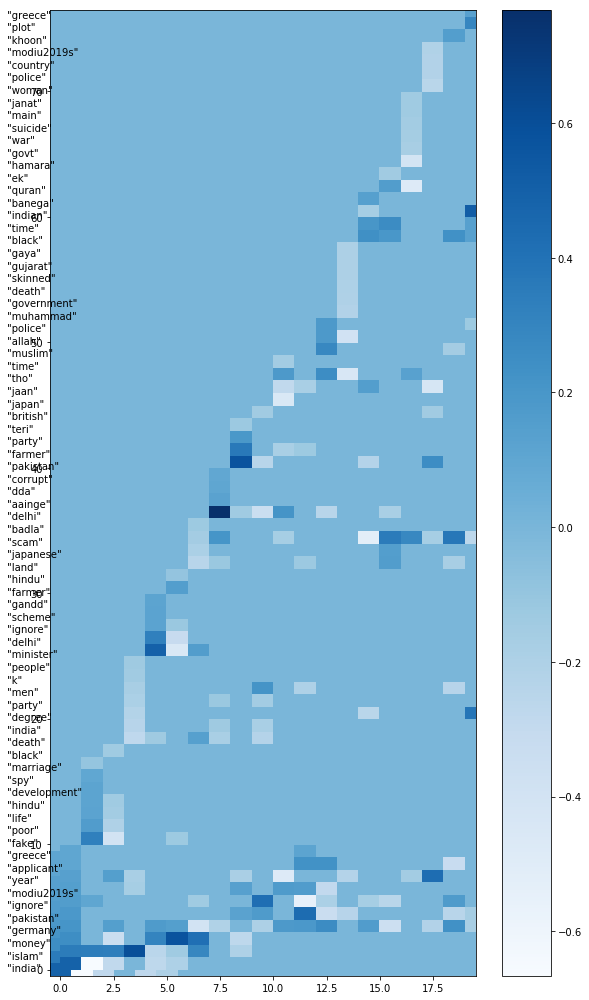

In [18]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


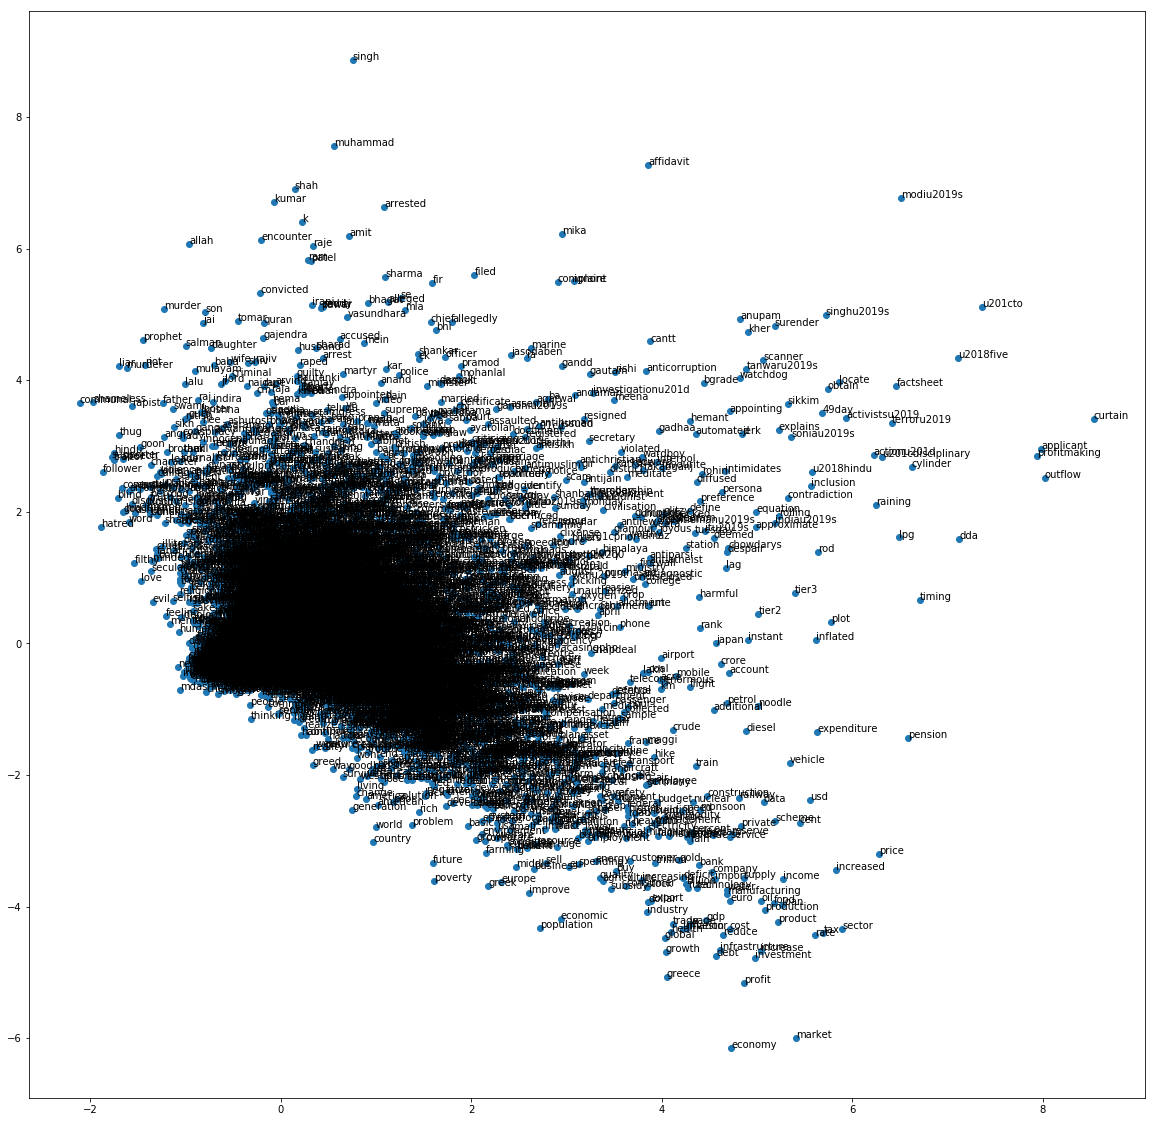

In [19]:
pca_scatter_graph(doc_cleaned)

# <div class="alert alert-block alert-info"><font color='red'> Anonymous user (Negative Comments) </font> </div>

In [20]:
# read the document
doc_cleaned = read_document('anony_negativecomment.txt')

Reading Document anony_negativecomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [21]:
frequency_doc = frequency_calculate(doc_cleaned)

In [24]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix,20)

In [25]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      13.696201        1       1  0.129308  0.212552
17     11.851207        1       2  0.268080 -0.147346
2       9.939161        1       3 -0.030320 -0.111373
18      9.834254        1       4 -0.073067  0.048752
4       8.700891        1       5 -0.056739 -0.045367
11      8.616118        1       6  0.019073 -0.027861
12      7.631282        1       7 -0.097871 -0.114196
6       6.460260        1       8  0.008171  0.058960
0       3.793528        1       9 -0.036162  0.001911
1       3.477173        1      10 -0.020079  0.000703
15      3.137359        1      11 -0.035049 -0.013093
10      3.064208        1      12 -0.025703  0.028459
13      2.740162        1      13 -0.024358  0.023984
3       2.195951        1      14 -0.007284  0.040988
16      1.555629        1      15 -0.015144  0.011643
14      1.390230        1      16  0.012236  0.005487
19      1.060010        1      17 -0.011935  0.011238
5       0.409940        1      18 -0.002765  0.005874
7       0.223218        1      19 -0.000169  0.004328
9       0.223218        1      20 -0.000221  0.004357, topic_info=     Category      Freq                   Term     Total  loglift  logprob
term                                                                      
595   Default  8.000000             government  8.000000  30.0000  30.0000
393   Default  7.000000                  local  7.000000  29.0000  29.0000
568   Default  5.000000                  judge  5.000000  28.0000  28.0000
585   Default  2.000000                 prison  2.000000  27.0000  27.0000
546   Default  4.000000               military  4.000000  26.0000  26.0000
424   Default  6.000000                husband  6.000000  25.0000  25.0000
392   Default  6.000000               employee  6.000000  24.0000  24.0000
530   Default  5.000000         administration  5.000000  23.0000  23.0000
620   Default  7.000000                 people  7.000000  22.0000  22.0000
651   Default  4.000000                article  4.000000  21.0000  21.0000
27    Default  2.000000                    kcr  2.000000  20.0000  20.0000
239   Default  2.000000               research  2.000000  19.0000  19.0000
495   Default  6.000000                  child  6.000000  18.0000  18.0000
710   Default  2.000000                   life  2.000000  17.0000  17.0000
478   Default  2.000000                  hindu  2.000000  16.0000  16.0000
124   Default  6.000000                  india  6.000000  15.0000  15.0000
605   Default  3.000000                   govt  3.000000  14.0000  14.0000
258   Default  3.000000                 thrown  3.000000  13.0000  13.0000
339   Default  2.000000                   jail  2.000000  12.0000  12.0000
20    Default  5.000000                   case  5.000000  11.0000  11.0000
729   Default  3.000000               prepared  3.000000  10.0000  10.0000
560   Default  3.000000                    mha  3.000000   9.0000   9.0000
748   Default  3.000000                   time  3.000000   8.0000   8.0000
59    Default  3.000000              christian  3.000000   7.0000   7.0000
192   Default  3.000000                holiday  3.000000   6.0000   6.0000
175   Default  3.000000              developed  3.000000   5.0000   5.0000
277   Default  3.000000                   city  3.000000   4.0000   4.0000
701   Default  2.000000                  limit  2.000000   3.0000   3.0000
21    Default  4.000000                  woman  4.000000   2.0000   2.0000
160   Default  2.000000                 filthy  2.000000   1.0000   1.0000
...       ...       ...                    ...       ...      ...      ...
750   Topic20  0.003582                 debate  1.010567   0.4623  -6.6214
246   Topic20  0.003582                provide  1.010567   0.4623  -6.6214
255   Topic20  0.003582             obligation  1.988984  -0.2148  -6.6214
254   Topic20  0.003582                   plea  1.063990   0.4108  -6

In [26]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'-0.432*"local" + -0.345*"government" + -0.288*"administration" + -0.184*"party" + -0.171*"called" + -0.171*"wrong" + -0.169*"delhi" + -0.161*"common" + -0.157*"condition" + -0.150*"voted"')
(1, u'0.455*"child" + 0.274*"husband" + 0.210*"seat" + 0.210*"car" + 0.169*"mother" + 0.144*"thrown" + 0.141*"prepared" + 0.141*"mha" + 0.141*"head" + 0.140*"lap"')
(2, u'0.362*"child" + -0.352*"husband" + -0.216*"thrown" + -0.213*"mha" + -0.213*"prepared" + 0.184*"car" + 0.184*"seat" + -0.142*"case" + -0.132*"woman" + 0.123*"driver"')
(3, u'0.607*"judge" + 0.287*"limit" + 0.234*"judiciary" + 0.192*"removed" + 0.192*"judgment" + 0.192*"delivers" + 0.192*"action" + 0.101*"nation" + 0.097*"freedom" + 0.096*"dictatorship"')
(4, u'-0.306*"india" + -0.228*"people" + -0.194*"indian" + -0.185*"military" + -0.147*"country" + -0.141*"city" + -0.141*"developed" + -0.128*"daughter" + -0.119*"read" + -0.119*"poison"')
(5, u'0.238*"india" + -0.186*"security" + -0.186*"official" + 0.184*"military" + -0.167*

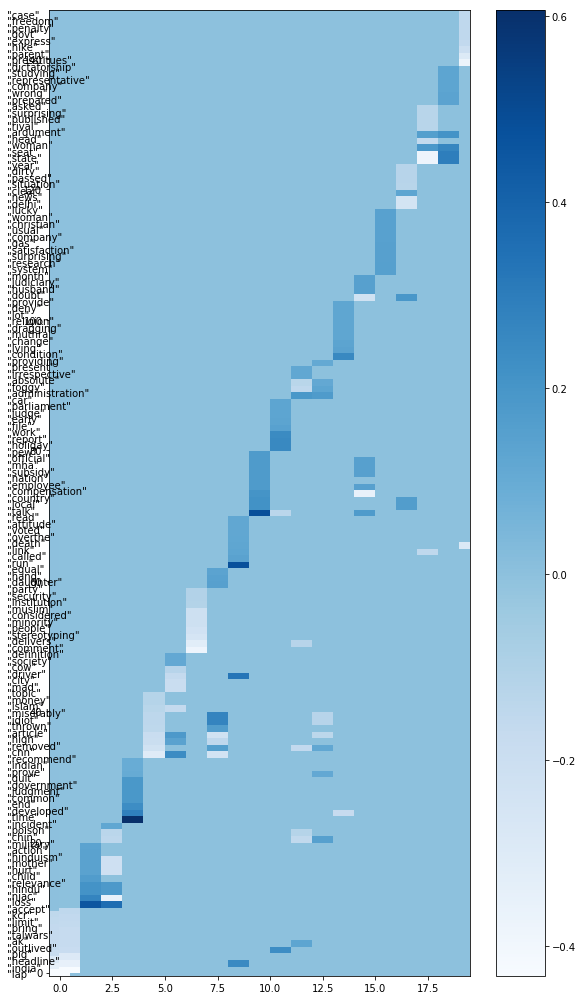

In [27]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


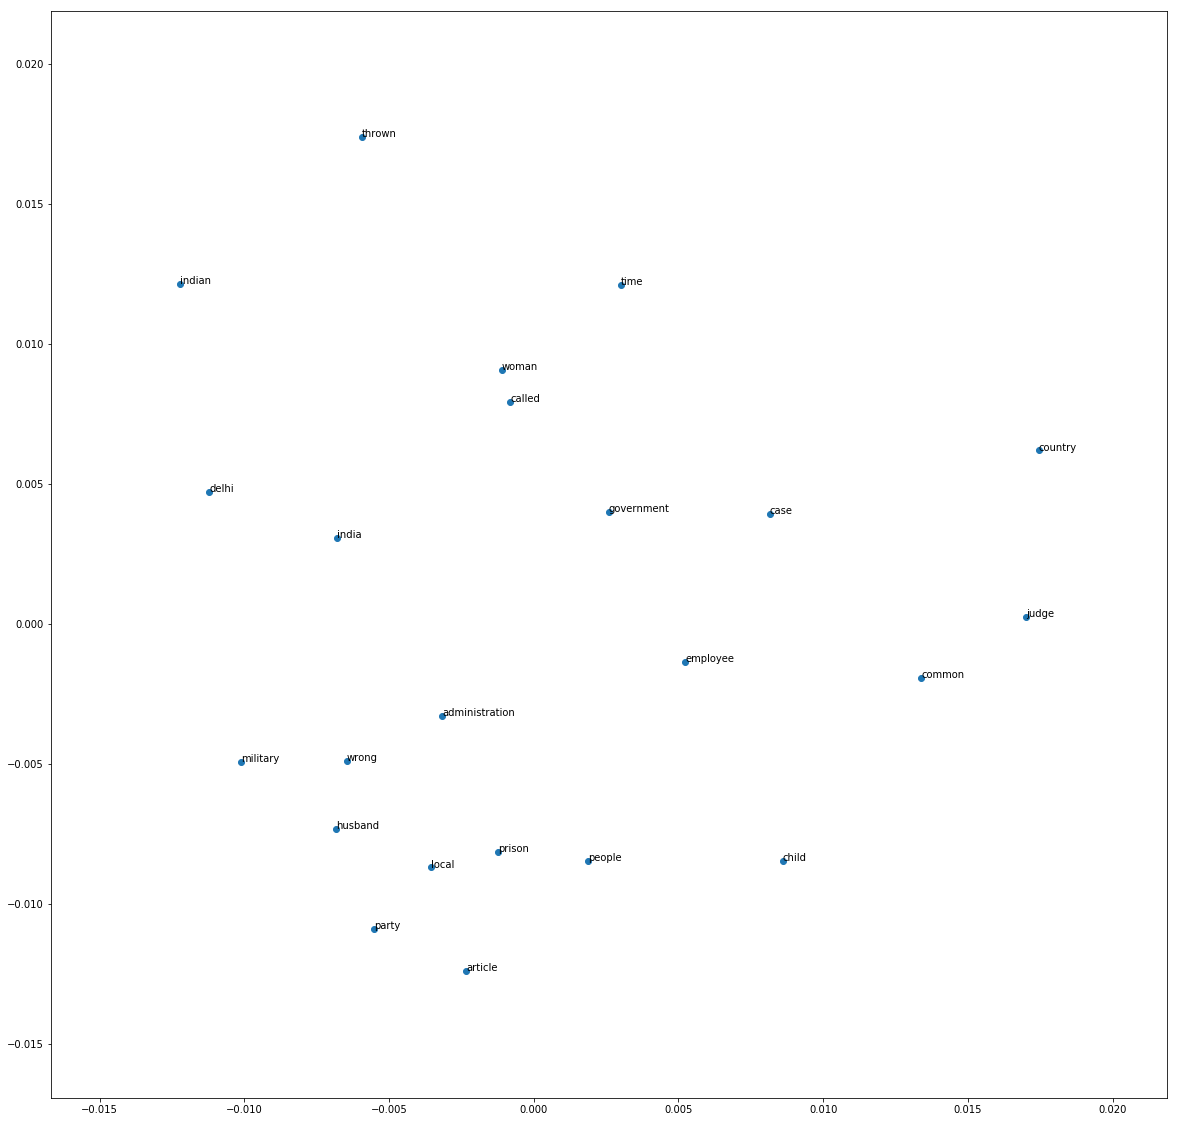

In [28]:
pca_scatter_graph(doc_cleaned)

# <div class="alert alert-block alert-info"><font color='red'> Users with Anonymous profiles (Negative Comments) </font> </div>

In [29]:
# read the document
doc_cleaned = read_document('null_negativecomment.txt')

Reading Document null_negativecomment.txt
Document Finished Reading
Document Cleaning Started
Document Cleaning Ended


In [30]:
frequency_doc = frequency_calculate(doc_cleaned)

In [31]:
dictionary, doc_term_matrix = prepare_lda_prerequisite(doc_cleaned)
ldamodel = run_lda(dictionary,doc_term_matrix)

In [32]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary)

/home/ubuntu/.virtualenvs/psu/local/lib/python2.7/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
33     6.600930        1       1 -0.337106  0.298510
18     2.924135        1       2 -0.123053 -0.140444
14     2.786247        1       3 -0.174449 -0.025656
43     2.039382        1       4 -0.137522 -0.066134
28     2.003649        1       5 -0.060046 -0.166410
3      1.843575        1       6 -0.058932 -0.067037
27     1.714754        1       7 -0.040443 -0.084312
65     1.499491        1       8 -0.024316  0.036157
80     1.462029        1       9 -0.084601 -0.085134
35     1.420566        1      10 -0.042454 -0.063389
94     1.413750        1      11 -0.097358  0.088931
41     1.348743        1      12 -0.059951 -0.021104
0      1.345010        1      13 -0.077941  0.019221
24     1.230036        1      14 -0.054907 -0.082958
79     1.212450        1      15 -0.023907 -0.029467
67     1.211162        1      16 -0.042695 -0.005399
73     1.204102        1      17 -0.025430 -0.022531
34     1.197972        1      18 -0.038257  0.062303
50     1.189944        1      19 -0.029048 -0.031276
19     1.166018        1      20 -0.048539 -0.061658
74     1.141858        1      21 -0.004818 -0.037147
46     1.138283        1      22 -0.006264 -0.054686
84     1.120235        1      23 -0.024019 -0.041095
70     1.095777        1      24 -0.037576 -0.052367
60     1.092297        1      25 -0.013651 -0.081170
96     1.085386        1      26 -0.008614  0.008296
63     1.077546        1      27  0.002954  0.000770
93     1.073683        1      28 -0.043272 -0.030933
21     1.070739        1      29 -0.034189  0.042378
71     1.046015        1      30 -0.032417 -0.035804
...         ...      ...     ...       ...       ...
42     0.732594        1      71 -0.010244  0.009277
23     0.731265        1      72  0.041609  0.009428
54     0.725630        1      73  0.025960  0.002954
99     0.717284        1      74  0.045732  0.002102
4      0.717012        1      75  0.001676  0.033546
10     0.715979        1      76  0.022951  0.012901
83     0.701305        1      77 -0.019723  0.081849
85     0.692493        1      78  0.021715  0.028978
68     0.689546        1      79  0.028117  0.016525
69     0.678929        1      80  0.048953 -0.006959
61     0.677502        1      81  0.013755  0.055492
76     0.676536        1      82  0.037651  0.009302
25     0.617538        1      83  0.063629  0.012224
90     0.615672        1      84  0.037890 -0.048274
2      0.613703        1      85  0.074649  0.048152
9      0.591369        1      86  0.058100  0.054834
40     0.577124        1      87  0.041491 -0.029202
16     0.573812        1      88  0.021943  0.063343
52     0.559675        1      89  0.067749  0.022283
7      0.549358        1      90  0.062352 -0.006294
91     0.499199        1      91  0.061937 -0.007555
36     0.481845        1      92  0.071446  0.075879
64     0.480994        1      93  0.091443  0.041832
89     0.476618        1      94  0.057832 -0.008511
57     0.470551        1      95  0.089310  0.029740
97     0.463997        1      96  0.069164  0.030452
47     0.435881        1      97  0.069880  0.006404
95     0.352438        1      98  0.101659  0.028394
13     0.342472        1      99  0.108709  0.066894
11     0.334209        1     100  0.088387  0.076956

[100 rows x 5 columns], topic_info=      Category        Freq           Term       Total  loglift  logprob
term                                                                   
7206   Default  239.000000  antislaughter  239.000000  30.0000  30.0000
7583   Default  239.000000      recognise  239.000000  29.0000  29.0000
3277   Default  239.000000      selective  239.000000  28.0000  28.0000
70     Default  239.000000        culling  239.000000  27.0000  27.0000
4368   Default  241.000000         permit  241.000000  26.0000  26.0000
4902   Default  242.000000      donu2019t  242.000000  25.0000  25.0000
2492   Default  26

In [33]:
lsimodel = run_lsi(doc_term_matrix,dictionary,20)
print_lsi(lsimodel)

(0, u'-0.240*"state" + -0.216*"indian" + -0.215*"law" + -0.199*"country" + -0.198*"future" + -0.186*"cow" + -0.184*"party" + -0.181*"reality" + -0.180*"donu2019t" + -0.180*"permit"')
(1, u'0.238*"cow" + 0.235*"law" + 0.234*"antislaughter" + 0.234*"culling" + 0.234*"selective" + 0.234*"recognise" + 0.234*"reality" + 0.234*"permit" + 0.233*"donu2019t" + 0.226*"future"')
(2, u'0.339*"woman" + -0.246*"cashless" + 0.242*"r" + 0.239*"country" + -0.232*"economy" + 0.227*"leader" + -0.217*"cooperative" + 0.160*"party" + -0.159*"colonized" + -0.152*"indian"')
(3, u'-0.401*"party" + -0.297*"people" + 0.200*"r" + 0.194*"woman" + -0.193*"delhi" + 0.180*"gandhi" + 0.171*"leader" + 0.141*"cashless" + -0.123*"government" + 0.123*"economy"')
(4, u'-0.299*"derc" + 0.258*"party" + -0.239*"electricity" + -0.228*"government" + -0.228*"delhi" + 0.202*"people" + -0.198*"staff" + -0.191*"section" + -0.187*"direction" + -0.182*"rule"')
(5, u'-0.549*"money" + -0.493*"black" + -0.215*"name" + -0.151*"court" + 0

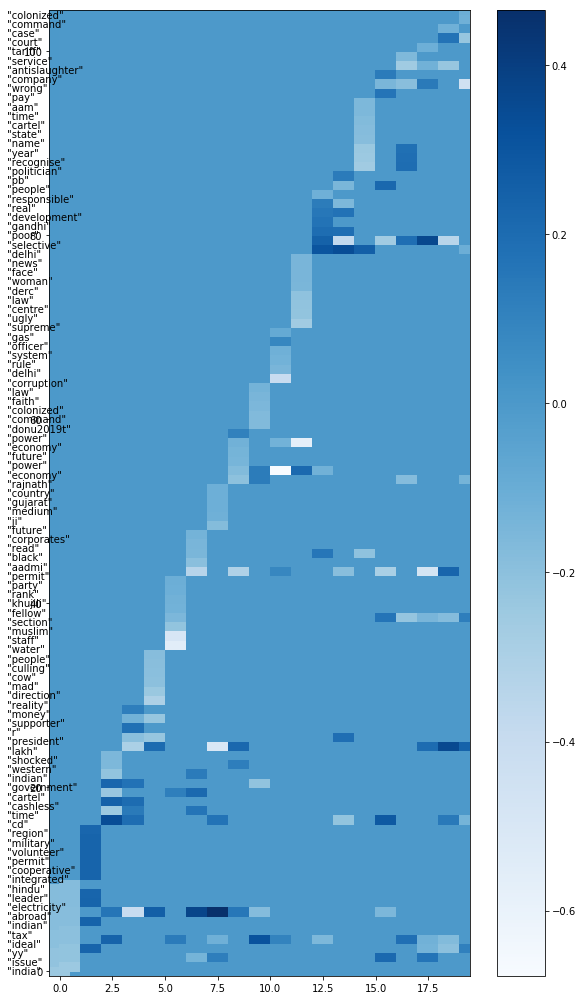

In [34]:
heat_map(lsimodel)

/home/ubuntu/.virtualenvs/psu/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


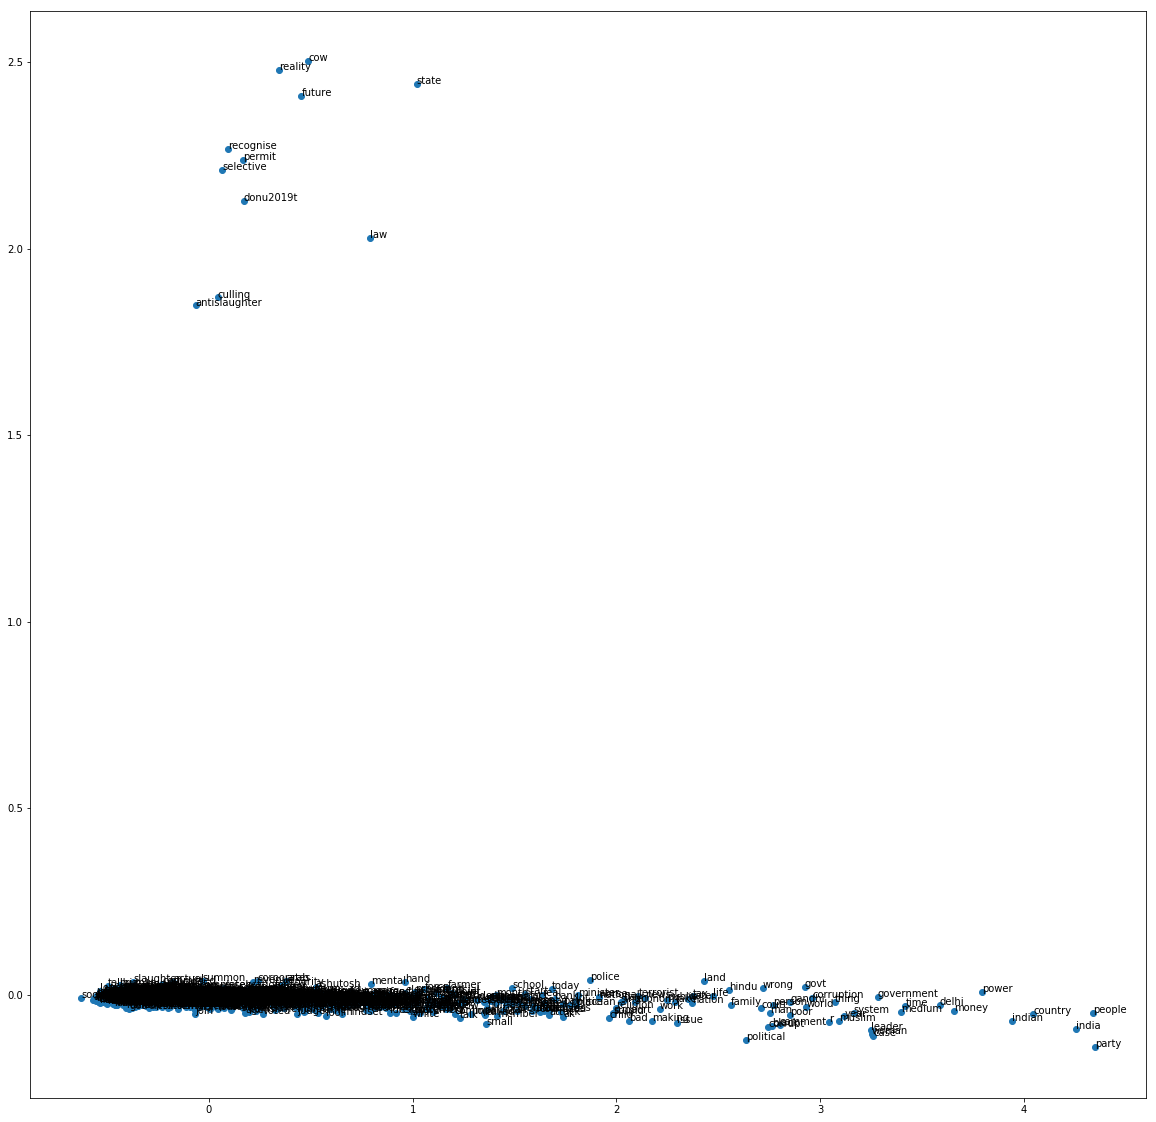

In [35]:
pca_scatter_graph(doc_cleaned)